In [1]:
import sys
sys.path.append('mobileNet-v2_cifar10__bloc_diag_utils')

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch

import copy
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytz
import time

from network import MobileNetV2
from StructuralBlocDiagMobileNetV2 import StructuralBlocDiagMobileNetV2
from util import test
from bloc_diag_utils import translate_nonzero_blocks

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### bloc diag MobileNetV2

In [4]:
config = {
    'model_name': 'MobileNetV2_bloc_diag',
    'dataset_name': 'CIFAR-10',
    'config_name': 'config2',
    'layer_sizes': [1250, 250, 50, 10, 10],
    'nonzero_blocks': '[2]*125 | [10]*125, [2]*25 | [10]*25, [2]*5 | [10]*5, [10]*1 | [10]*1',
    'fc_if_bias': False,
    'fc_nonlinear_activation': 'SiLU__every_layer_except_last',
    'starting_learning_rate': 1e-3,
    'weight_decay': 4e-5,
    'scheduler': 'cosine annealing',
    'T_max': 300,
    'eta_min': 1e-6,
    'stopping_epoch': 300,
    'train_loader_batch_size': 384,
    'multiplier_off_diag_loss': 0.1
}

#### original MobileNetV2

In [5]:
config = {
    'model_name': 'MobileNetV2_bloc_diag',
    'dataset_name': 'CIFAR-10',
    'config_name': 'original_network',
    'layer_sizes': [1280, 10],
    'nonzero_blocks': '[10]*1 | [1280]*1',
    'fc_if_bias': True,
    'fc_nonlinear_activation': 'none',
    'starting_learning_rate': 1e-3,
    'weight_decay': 4e-5,
    'scheduler': 'cosine annealing',
    'T_max': 300,
    'eta_min': 1e-6,
    'stopping_epoch': 300,
    'train_loader_batch_size': 384,
    'multiplier_off_diag_loss': 0.0
}

In [5]:
df_to_fine_tune = pd.read_csv("bloc_diag_MobileNetV2__test_results__dataset=CIFAR-10.csv")

#### fine tune configurations

In [10]:
fine_tune_config = {
    'model_name': 'MobileNetV2_structural_bloc_diag',
    'dataset_name': 'CIFAR-10',
    'config_name': 'config2',
    'layer_sizes': [1250, 250, 50, 10, 10],
    'nonzero_blocks': '[2]*125 | [10]*125, [2]*25 | [10]*25, [2]*5 | [10]*5, [10]*1 | [10]*1',
    'fc_if_bias': False,
    'fc_nonlinear_activation': 'SiLU__every_layer_except_last',
    'starting_learning_rate': 1e-4,
    'weight_decay': 4e-5,
    'scheduler': 'cosine annealing',
    'T_max': 250,
    'eta_min': 1e-6,
    'stopping_epoch': 250,
    'train_loader_batch_size': 384
}

In [8]:
### model folder directory
dir_bd_model_folder = "bloc_diag_mobileNetV2__models"
dir_sbd_model_folder = "structural_bloc_diag_mobileNetV2__models"
df_path = f"structural_bloc_diag_MobileNetV2__test_results__dataset={fine_tune_config['dataset_name']}.csv"
if os.path.exists(df_path):
    df_results = pd.read_csv(df_path)
else:
    df_results = pd.DataFrame()

# load data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_CIFAR10 = CIFAR10("/home/tinyalpha/dataset/cifar10", transform = transform_train, train=True, download=True)
test_CIFAR10 = CIFAR10("/home/tinyalpha/dataset/cifar10", transform = transform_test, train=False, download=True)
train_loader = torch.utils.data.DataLoader(train_CIFAR10, batch_size = config['train_loader_batch_size'], shuffle = True, num_workers = 6)
test_loader = torch.utils.data.DataLoader(test_CIFAR10, batch_size = 192, shuffle = False, num_workers = 6)

Files already downloaded and verified
Files already downloaded and verified


StructuralBlocDiagMobileNetV2 weights successfully set. Initial test loss = 0.6582. Initial test accu: 0.9203
Epoch 1 time: 38.41s
Epoch 2 time: 38.20s
Epoch 3 time: 37.82s
Epoch 4 time: 36.74s
Epoch 5 time: 35.52s
Epoch 6 time: 35.33s
Epoch 7 time: 35.51s
Epoch 8 time: 35.54s
Epoch 9 time: 35.59s
Epoch 10: Train Loss: 0.0005, Train Accu: 0.9999, Test Loss: 0.6796, Test Accu: 0.9189
Epoch 10 time: 46.56s
Epoch 11 time: 35.23s
Epoch 12 time: 35.15s
Epoch 13 time: 35.28s
Epoch 14 time: 35.31s
Epoch 15 time: 35.23s
Epoch 16 time: 35.56s
Epoch 17 time: 35.69s
Epoch 18 time: 35.36s
Epoch 19 time: 35.32s
Epoch 20: Train Loss: 0.0006, Train Accu: 0.9999, Test Loss: 0.7049, Test Accu: 0.9187
Epoch 20 time: 46.57s
Epoch 21 time: 35.52s
Epoch 22 time: 35.29s
Epoch 23 time: 35.66s
Epoch 24 time: 35.51s
Epoch 25 time: 35.62s
Epoch 26 time: 35.35s
Epoch 27 time: 35.46s
Epoch 28 time: 35.38s
Epoch 29 time: 35.16s
Epoch 30: Train Loss: 0.0004, Train Accu: 0.9998, Test Loss: 0.7180, Test Accu: 0.9164


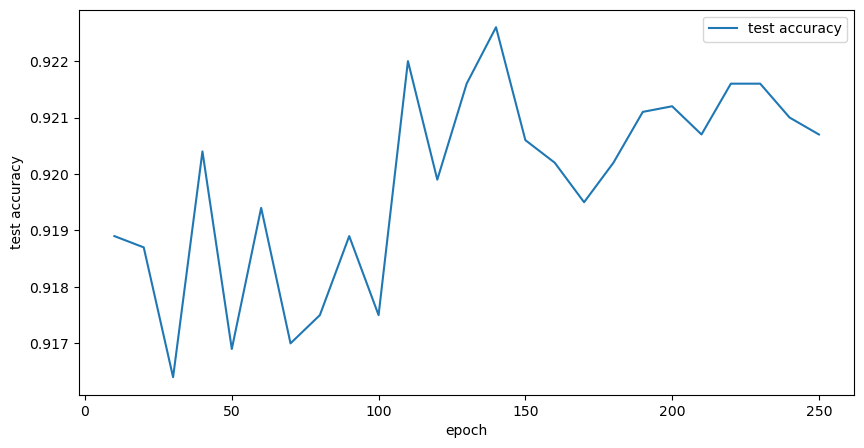

Total training time: 2.6 h


In [11]:
EST_time_zone = pytz.timezone('US/Eastern')


for index, row in df_to_fine_tune.iterrows():
    dict_to_save = row.to_dict()

    ### rearrange the dict
    dict_to_save['model_name'] = fine_tune_config['model_name']
    dict_to_save['dataset_name'] = fine_tune_config['dataset_name']
    dict_to_save['config_name'] = fine_tune_config['config_name']
    dict_to_save['layer_sizes'] = fine_tune_config['layer_sizes']
    dict_to_save['nonzero_blocks'] = fine_tune_config['nonzero_blocks']
    dict_to_save['fc_if_bias'] = fine_tune_config['fc_if_bias']
    dict_to_save['fc_nonlinear_activation'] = fine_tune_config['fc_nonlinear_activation']

    _ = dict_to_save.pop('starting_learning_rate', 'No such key')
    _ = dict_to_save.pop('weight_decay', 'No such key')
    _ = dict_to_save.pop('scheduler', 'No such key')
    _ = dict_to_save.pop('T_max', 'No such key')
    _ = dict_to_save.pop('eta_min', 'No such key')
    _ = dict_to_save.pop('stopping_epoch', 'No such key')
    _ = dict_to_save.pop('train_loader_batch_size', 'No such key')
    _ = dict_to_save.pop('multiplier_off_diag_loss', 'No such key')
    _ = dict_to_save.pop('test_accuracy_before_dropping', 'No such key')
    _ = dict_to_save.pop('time_consumption(s)', 'No such key')

    dict_to_save['random_seed__before_fine_tune'] = dict_to_save['random_seed']
    _ = dict_to_save.pop('random_seed', 'No such key')
    dict_to_save['time__before_fine_tune'] = dict_to_save['time']
    _ = dict_to_save.pop('time', 'No such key')
    dict_to_save['train_accuracy__before_fine_tune'] = dict_to_save['train_accuracy']
    _ = dict_to_save.pop('train_accuracy', 'No such key')
    dict_to_save['test_accuracy_off_diag_dropped__before_fine_tune'] = dict_to_save['test_accuracy_off_diag_dropped']
    _ = dict_to_save.pop('test_accuracy_off_diag_dropped', 'No such key')

    ### update configs for fine tuning
    dict_to_save['starting_learning_rate'] = fine_tune_config['starting_learning_rate']
    dict_to_save['weight_decay'] = fine_tune_config['weight_decay']
    dict_to_save['scheduler'] = fine_tune_config['scheduler']
    dict_to_save['T_max'] = fine_tune_config['T_max']
    dict_to_save['eta_min'] = fine_tune_config['eta_min']
    dict_to_save['stopping_epoch'] = fine_tune_config['stopping_epoch']
    dict_to_save['train_loader_batch_size'] = fine_tune_config['train_loader_batch_size']
    
    dict_to_save['random_seed'] = dict_to_save['random_seed__before_fine_tune']



    torch.manual_seed(dict_to_save['random_seed'])
    np.random.seed(dict_to_save['random_seed'])


    # Initialize BlocDiagModel
    row_blocks, col_blocks = translate_nonzero_blocks(dict_to_save['nonzero_blocks'])
    
    pretrained_bd_model = MobileNetV2(dict_to_save['layer_sizes'], row_blocks, col_blocks,
                                      dict_to_save['fc_if_bias'], dict_to_save['fc_nonlinear_activation'])
    pretrained_bd_model_path = (
        f"{dir_bd_model_folder}"
        f"\\MobileNetV2_bloc_diag__data={dict_to_save['dataset_name']}__{dict_to_save['config_name']}__{dict_to_save['time__before_fine_tune']}.pt"
    )
    pretrained_bd_model.load_state_dict(torch.load(pretrained_bd_model_path))
    
    # Initialize StructuralBlocDiagModel
    sbd_model = StructuralBlocDiagMobileNetV2(dict_to_save['layer_sizes'], row_blocks, col_blocks,
                                              dict_to_save['fc_if_bias'], dict_to_save['fc_nonlinear_activation'])
    ### load weights except fc layers
    state_dict = torch.load(pretrained_bd_model_path)
    state_dict_except_fc_weights = dict(list(state_dict.items())[:-4])  ### because there are only 4 fc weights
    sbd_model.load_state_dict(state_dict_except_fc_weights, strict=False)
    ### load weights for fc layers
    fc_weights_list = [param.data for name, param in pretrained_bd_model.named_parameters() if 'layers' in name]
    sbd_model.set_all_layers_from_full_matrices(fc_weights_list)
    sbd_model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy = test(sbd_model, test_loader, criterion, device)
    # Print and log the metrics
    print(f"StructuralBlocDiagMobileNetV2 weights successfully set. Initial test loss = {test_loss:.4f}. Initial test accu: {test_accuracy:.4f}")



    ### begin training
    start_time = time.time()

    optimizer = optim.AdamW(sbd_model.parameters(), lr=dict_to_save['starting_learning_rate'], weight_decay=dict_to_save['weight_decay'])
    if dict_to_save['scheduler'] == 'cosine annealing':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=dict_to_save['T_max'], eta_min=dict_to_save['eta_min'])
    else:
        raise ValueError("scheduler is unspecified")


    test_accuracies = []


    for epoch in range(dict_to_save['stopping_epoch']):
        epoch_start_time = time.time()
    
        # Initialize metrics
        correct, total, train_loss, counter = 0, 0, 0, 0
    
        # Training loop
        for data in train_loader:
            sbd_model.train()  # Set model to training mode
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            # Forward pass and loss calculation
            outputs = sbd_model(inputs)
            loss = criterion(outputs, labels) ### no need to drop off-diag terms, sbd_models don't have those terms
    
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # Update training metrics
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loss += loss.item()
            counter += 1
    
        # Evaluate on the test set every 10 epochs
        if (epoch + 1) % 10 == 0:
            train_accuracy = correct / total
            avg_train_loss = train_loss / counter
            test_loss, test_accuracy = test(sbd_model, test_loader, criterion, device)
            test_accuracies.append(test_accuracy)
    
            # Print and optionally log the metrics
            print(f'Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Train Accu: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accu: {test_accuracy:.4f}')
    
        scheduler.step()
        # Report epoch duration
        print("Epoch {} time: {:.2f}s".format(epoch + 1, time.time() - epoch_start_time))
    
    
    current_time_est = datetime.datetime.now(EST_time_zone)
    time_str = current_time_est.strftime("%Y-%m-%d_%H-%M-%S")

    ### save the model
    torch.save(sbd_model.state_dict(), f"{dir_sbd_model_folder}/{dict_to_save['model_name']}__data={dict_to_save['dataset_name']}__{dict_to_save['config_name']}__{time_str}.pt")
    torch.save(optimizer.state_dict(), f"{dir_sbd_model_folder}/optimizer__{dict_to_save['model_name']}__data={dict_to_save['dataset_name']}__{dict_to_save['config_name']}__{time_str}.pt")

    end_time = time.time()
    print(f'Time consumption: {end_time - start_time}')
    
    dict_to_save['time'] = time_str
    dict_to_save['train_accuracy'] = train_accuracy
    dict_to_save['test_accuracy'] = test_accuracy
    dict_to_save['time_consumption(s)'] = end_time - start_time

    ### save result to spreadsheet
    df_results = pd.concat([df_results, pd.DataFrame([dict_to_save])], ignore_index=True)
    df_results.to_csv(df_path, index=False)



    plt.figure(figsize=(10, 5))
    plt.plot(list(range(10, dict_to_save['stopping_epoch']+1, 10)), test_accuracies, label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('test accuracy')
    plt.legend()
    plt.show()

    print("Total training time: {:.1f} h".format((time.time() - start_time) / 3600))